## Описание проекта

**Цель:** Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.Нужно выбрать из двух тарифных планов **«Смарт»** и **«Ультра»**

**Выборка**: В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Описание данных**

***Таблица users (информация о пользователях):***
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

***Таблица calls (информация о звонках):***
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

***Таблица messages (информация о сообщениях):***
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

***Таблица internet (информация об интернет-сессиях):***
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

***Таблица tariffs (информация о тарифах):***
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* vminutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* vrub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
# Необходимые библиотеки для исследования 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np    
from scipy import stats as st
import seaborn as sns

In [2]:
# Загрузим входные данные по очереди

try:
    df_calls = pd.read_csv('calls.csv')
except FileNotFoundError as e:
    print(repr(e))
    df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.head(3)

FileNotFoundError(2, 'No such file or directory')


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


In [3]:
try:
    df_internet = pd.read_csv('internet.csv')
except FileNotFoundError as e:
    print(repr(e))
    df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.head(3)

FileNotFoundError(2, 'No such file or directory')


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


In [4]:
try:
    df_messages = pd.read_csv('messages.csv')
except FileNotFoundError as e:
    print(repr(e))
    df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.head(3)

FileNotFoundError(2, 'No such file or directory')


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


In [5]:
try:
    df_tariffs = pd.read_csv('tariffs.csv')
except FileNotFoundError as e:
    print(repr(e))
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs.head(3)

FileNotFoundError(2, 'No such file or directory')


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
try:
    df_users = pd.read_csv('users.csv')
except FileNotFoundError as e:
    print(repr(e))
    df_users = pd.read_csv('/datasets/users.csv')
df_users.head(3)

FileNotFoundError(2, 'No such file or directory')


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


### Подготовка данных

* Пропуски
* Дубликаты
* Типы данных

In [7]:
def first_look(df):
    print('-------- Первые 3 строки --------')
    display(df.head(3))
    
    print('-------- Типы данных --------')
    df.info()
    print('-------- Пропуски --------')
    
    if df.isna().sum().sum() == 0:
        print('Пропусков нет')
    else:
        print('Пропуски есть')
        print(df.isna().sum())        
        
    print('-------- Явные дубликаты --------')
    if df.duplicated().sum() <= 0:
        print('Дубликатов нет')
    else:
        print('Дубликаты есть', df.duplicated().sum())

In [8]:
def hist_maker(column):
    print(column.describe())
    plt.figure(figsize=(10,3))
    plt.hist(column, bins=30, color='blue', edgecolor='grey', alpha=0.4)
    plt.axvline(column.describe()['mean'], color='r', linestyle='dashed', linewidth=3, label='Mean value')
    plt.axvline(column.describe()['50%'], color='b', linestyle='dotted', linewidth=3, label='50% value')
    plt.legend()
    plt.title('Histogramm {}'.format(column.name))

-------- Первые 3 строки --------


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


-------- Типы данных --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
-------- Пропуски --------
Пропусков нет
-------- Явные дубликаты --------
Дубликатов нет
count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64


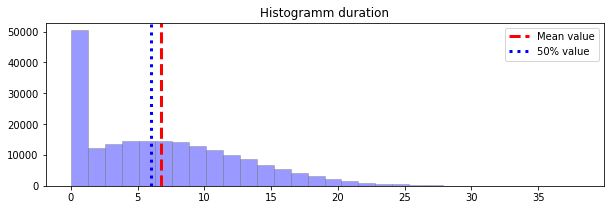

In [9]:
first_look(df_calls)
hist_maker(df_calls['duration'])

**Интресное про звонки:**
* Большенство звонков нулевые, возможно это не состоявшиеся\не дозвонившиеся звонки
* В среднем клинеты разговаривают чуть около 7 минут 
* Максимальный разговор 38 минут

-------- Первые 3 строки --------


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


-------- Типы данных --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
-------- Пропуски --------
Пропусков нет
-------- Явные дубликаты --------
Дубликатов нет
count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64


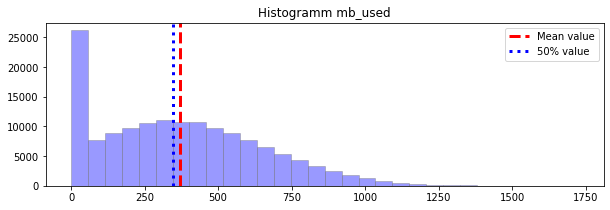

In [10]:
first_look(df_internet)
hist_maker(df_internet['mb_used'])

**Интресное про интернет:**
* Так же большое колличество нулевого трафика, будем считать это или сбоями или пользователие мессенджерами, которое не тарифицируется и обнуляется компанией
* Среднее значение и 50% практически совпадает и находится в районе 350 мб за одну сессию
* Форма распередления очень похоже на нормальное распределение

-------- Первые 3 строки --------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


-------- Типы данных --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
-------- Пропуски --------
Пропусков нет
-------- Явные дубликаты --------
Дубликатов нет
              id  user_id
message_date             
2018-01-02    10       10
2018-01-03     4        4
2018-01-04    10       10
count    364.000000
mean     338.010989
std      207.856660
min        4.000000
25%      147.750000
50%      335.000000
75%      521.250000
max      859.000000
Name: id, dtype: float64


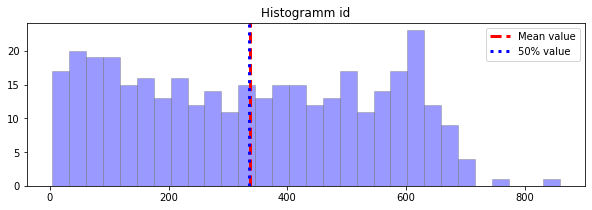

In [11]:
first_look(df_messages)
df_messages_group = df_messages.groupby('message_date').count()
print(df_messages_group.head(3))
hist_maker(df_messages_group['id'])

**Интресное про сообщения:**
* На гисторграмме видно, что явного пика с максимумом нет и у Клинетов разные стили использования сообщений
* В среднем это 300 сообщений в день, но более 600 сообщений уже мало кто рассылает в день

In [12]:
first_look(df_tariffs)

-------- Первые 3 строки --------


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


-------- Типы данных --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
-------- Пропуски --------
Пропусков нет
-------- Явные дубликаты --------
Дубликатов нет


In [13]:
# Переименуем колонку tariff_name на tariff, чтобы потом можно было соединять таблицы
df_tariffs = df_tariffs.rename(columns={'tariff_name': 'tariff'})

In [14]:
first_look(df_users)

-------- Первые 3 строки --------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


-------- Типы данных --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
-------- Пропуски --------
Пропуски есть
user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64
-------- Явные дубликаты --------
Дубликатов нет


**Какие можно сделать выводы**
* Необходимо для дат изменить тип данных на date: call_date, message_date, reg_date, session_date 
* Необходимо произветси округления длительность звонка до целого числа минут в большую сторону, а так же для интернета, но по месяцам
* Обнаружилось, что есть пустые значения в поле дата оттока (churn_date) - это значит, что клиент является клиентом «Мегалайн» на текущий момент
* по условию задачи - нулями обозначены пропущенные звонки, поэтому их не нужно удалять, а посчитем как не отвеченные зконки

### Проведем предобработку  и  агрегацию данных

Агрегация из задания: 
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;

In [15]:
# Перевод дат из объектного типа в тип datetime64
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

In [16]:
# Округляем длительность звонков и меняем тип данных на целочисленный
df_calls['duration'] = np.ceil(df_calls['duration']).astype('int')
df_calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000


In [17]:
# Добавляем столбец с началом календарного месяца, чтобы потом можно было по этому полю сгруппироваться
df_calls['month'] = df_calls['call_date'].astype('datetime64[M]') 
df_internet['month'] = df_internet['session_date'].astype('datetime64[M]')
df_messages['month'] = df_messages['message_date'].astype('datetime64[M]')

In [18]:
# Рассчитаем количество сделанных звонков и израсходованные минуты по месяцам
group_call = df_calls.groupby(['user_id','month']).agg({'id':'count', 'duration':'sum'}).reset_index()
group_call = group_call.rename(columns={'id': 'calls_count', 'duration': 'calls_duration'})
group_call.head(10)

#calls = df_calls.groupby(['user_id','month']).agg(
 #       calls_duration = pd.NamedAgg(column = 'duration', aggfunc = 'sum'),
  #      calls_number = ( 'id', 'count'),
   # ).reset_index()

,user_id,month,calls_count,calls_duration
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466
5,1000,2018-10-01,57,350
6,1000,2018-11-01,43,338
7,1000,2018-12-01,46,333
8,1001,2018-11-01,59,430
9,1001,2018-12-01,63,414


In [19]:
group_call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3174 non-null   int64         
 1   month           3174 non-null   datetime64[ns]
 2   calls_count     3174 non-null   int64         
 3   calls_duration  3174 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 99.3 KB


In [20]:
# Рассчитаем количество отправленных сообщений по месяцам
group_messages = df_messages.groupby(['user_id','month']).agg('id').count().reset_index()
group_messages = group_messages.rename(columns={'id': 'messages_count'})

group_messages.head(8)

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
5,1000,2018-10-01,73
6,1000,2018-11-01,58
7,1000,2018-12-01,70


In [21]:
group_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         2717 non-null   int64         
 1   month           2717 non-null   datetime64[ns]
 2   messages_count  2717 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 63.8 KB


In [22]:
# Рассчитаем месячный трафик каждого пользователя
group_internet = df_internet.groupby(['user_id', 'month']).agg('mb_used').sum().reset_index()
group_internet.head(10)

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91
5,1000,2018-10-01,14702.49
6,1000,2018-11-01,14756.47
7,1000,2018-12-01,9817.61
8,1001,2018-11-01,18429.34
9,1001,2018-12-01,14036.66


In [23]:
# Округлим месячный трафик каждого пользователя до ближайшего гБ
group_internet['gb_used'] = group_internet['mb_used']/1024
group_internet['gb_used'] = np.ceil(group_internet['gb_used']).astype('int')
group_internet.head(8)

,user_id,month,mb_used,gb_used
0,1000,2018-05-01,2253.49,3
1,1000,2018-06-01,23233.77,23
2,1000,2018-07-01,14003.64,14
3,1000,2018-08-01,14055.93,14
4,1000,2018-09-01,14568.91,15
5,1000,2018-10-01,14702.49,15
6,1000,2018-11-01,14756.47,15
7,1000,2018-12-01,9817.61,10


In [24]:
# Cоберем данные о смс и интренете в одну таблицу
data = group_messages.merge(group_internet, on=['user_id', 'month'], how='outer')
display(data.head(5))
data.info()

,user_id,month,messages_count,mb_used,gb_used
0,1000,2018-05-01,22.0,2253.49,3.0
1,1000,2018-06-01,60.0,23233.77,23.0
2,1000,2018-07-01,75.0,14003.64,14.0
3,1000,2018-08-01,81.0,14055.93,14.0
4,1000,2018-09-01,57.0,14568.91,15.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   month           3214 non-null   datetime64[ns]
 2   messages_count  2717 non-null   float64       
 3   mb_used         3203 non-null   float64       
 4   gb_used         3203 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 150.7 KB


In [25]:
# У Клинетов, которые использоваль только одной услугой, могут быть Nan. 
# Предлагаю для них заполнить пустые значение нулем
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   month           3214 non-null   datetime64[ns]
 2   messages_count  3214 non-null   float64       
 3   mb_used         3214 non-null   float64       
 4   gb_used         3214 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 150.7 KB


In [26]:
# Добавим данные о звонках в одну таблицу и у клиентов не пользующихся звонками заполним пустые значения нулем
data = data.merge(group_call, on=['user_id', 'month'], how='outer')
data = data.fillna(0)
display(data.head(5))
data.info()

,user_id,month,messages_count,mb_used,gb_used,calls_count,calls_duration
0,1000,2018-05-01,22.0,2253.49,3.0,22.0,159.0
1,1000,2018-06-01,60.0,23233.77,23.0,43.0,172.0
2,1000,2018-07-01,75.0,14003.64,14.0,47.0,340.0
3,1000,2018-08-01,81.0,14055.93,14.0,52.0,408.0
4,1000,2018-09-01,57.0,14568.91,15.0,58.0,466.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   month           3214 non-null   datetime64[ns]
 2   messages_count  3214 non-null   float64       
 3   mb_used         3214 non-null   float64       
 4   gb_used         3214 non-null   float64       
 5   calls_count     3214 non-null   float64       
 6   calls_duration  3214 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 200.9 KB


In [27]:
# Добавим данные о пользоватале в одну таблицу
# data = data.merge(df_users, on=['user_id'], how='outer') 
# есть пользователи, которые не пользовались услугами, для анализа они нам не нужны по этому удалим их, используя how='left'
data = data.merge(df_users, on=['user_id'], how='left')
display(data.head(5))
data.info()

,user_id,month,messages_count,mb_used,gb_used,calls_count,calls_duration,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,22.0,2253.49,3.0,22.0,159.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,60.0,23233.77,23.0,43.0,172.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,75.0,14003.64,14.0,47.0,340.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,81.0,14055.93,14.0,52.0,408.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,57.0,14568.91,15.0,58.0,466.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   month           3214 non-null   datetime64[ns]
 2   messages_count  3214 non-null   float64       
 3   mb_used         3214 non-null   float64       
 4   gb_used         3214 non-null   float64       
 5   calls_count     3214 non-null   float64       
 6   calls_duration  3214 non-null   float64       
 7   age             3214 non-null   int64         
 8   churn_date      187 non-null    object        
 9   city            3214 non-null   object        
 10  first_name      3214 non-null   object        
 11  last_name       3214 non-null   object        
 12  reg_date        3214 non-null   datetime64[ns]
 13  tariff          3214 non-null   object        
dtypes: datetime64[ns](2), float64(5), int64(2), object(5)
me

In [28]:
# Добавим данные о тарифе в общую таблицу
data = data.merge(df_tariffs, on=['tariff'], how='left')
display(data.head(5))
data.info()

,user_id,month,messages_count,mb_used,gb_used,calls_count,calls_duration,age,churn_date,city,...,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,22.0,2253.49,3.0,22.0,159.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,60.0,23233.77,23.0,43.0,172.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,75.0,14003.64,14.0,47.0,340.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,81.0,14055.93,14.0,52.0,408.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,57.0,14568.91,15.0,58.0,466.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   datetime64[ns]
 2   messages_count         3214 non-null   float64       
 3   mb_used                3214 non-null   float64       
 4   gb_used                3214 non-null   float64       
 5   calls_count            3214 non-null   float64       
 6   calls_duration         3214 non-null   float64       
 7   age                    3214 non-null   int64         
 8   churn_date             187 non-null    object        
 9   city                   3214 non-null   object        
 10  first_name             3214 non-null   object        
 11  last_name              3214 non-null   object        
 12  reg_date               3214 non-null   datetime64[ns]
 13  tar

**Заметки**

* Есть 2 Клинета, которые не пользовались ни одной услугой за весь исследуемый период времени (год) и мы их удалили из данных.
* Если Клиент не пользовался услугой, то заполнили пропуски нулям аналогично как сделали с звонкам 
* Nan остаивла для даты оттока (churn_date) для случая если Клиент еще не расторг договор
* Количество строк получилось 3214 <= 6000 (500 пользователей * 12 месяцев) 

### Расчет выручки
* вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
* остаток умножьте на значение из тарифного плана; 
* прибавьте абонентскую плату, соответствующую тарифному плану

In [29]:
#знаю, что не идально написано и заводятся лишние переменные, зато не  подглядывала в шаблонную работу и написала сама 
def calculate_revenue(row):
    if (row['minutes_included'] - row['calls_duration'] < 0):
        row['row_extra_call'] = abs(row['minutes_included'] - row['calls_duration']) 
    else:
        row['row_extra_call'] = 0
        
    if (row['messages_included'] - row['messages_count'] < 0):
        row['row_extra_message'] = abs(row['messages_included'] - row['messages_count'])   
    else:
        row['row_extra_message'] = 0
        
    if (row['mb_per_month_included'] - row['mb_used'] < 0):
        row['row_extra_internet'] = np.ceil(abs(row['mb_per_month_included'] - row['mb_used'])/1024)
    else:
        row['row_extra_internet'] = 0        
        
    return  row['rub_monthly_fee'] + row['row_extra_call']*row['rub_per_minute'] + row['row_extra_message']*row['rub_per_message'] + row['row_extra_internet']*row['rub_per_gb']

In [30]:
# Рассчитаем помесячную выручку для каждого пользователя 
data['revenue'] = data.apply(calculate_revenue, axis=1)
data.head(5)

,user_id,month,messages_count,mb_used,gb_used,calls_count,calls_duration,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,2018-05-01,22.0,2253.49,3.0,22.0,159.0,52,NaN,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,2018-06-01,60.0,23233.77,23.0,43.0,172.0,52,NaN,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,2018-07-01,75.0,14003.64,14.0,47.0,340.0,52,NaN,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,2018-08-01,81.0,14055.93,14.0,52.0,408.0,52,NaN,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,2018-09-01,57.0,14568.91,15.0,58.0,466.0,52,NaN,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0


### Анализ тарифов

In [31]:
smart = data.query('tariff == "smart"')
ultra = data.query('tariff == "ultra"')

In [32]:
# Видно, что клиентов тарифа smart болеше чем 2 раза чем ultra
print('Кол-во клинетов smart:', smart['user_id'].count())
print('Кол-во клинетов ultra:', ultra['user_id'].count())

Кол-во клинетов smart: 2229
Кол-во клинетов ultra: 985


In [33]:
def boxpot_maker(data, column):
    print('Cреднее количество', data[column].mean())
    print('Дисперсия', np.std(data[column]))
    print('Стандартное отклонение', np.var(data[column]))    
    data.boxplot(column = column)
    plt.show()
    print(data[column].describe())
    print('-------')

In [34]:
def hist_maker_combi(column_smart, column_ultra):
    plt.figure(figsize=(10,3))
    plt.hist(column_smart, bins=30, color='blue', edgecolor='grey', alpha=0.4)
    plt.hist(column_ultra, bins=30, edgecolor='gray', alpha=0.4)
    plt.axvline(column_smart.describe()['mean'], color='r', linestyle='dashed', linewidth=3, label='Mean smast')
    plt.axvline(column_ultra.describe()['mean'], color='b', linestyle='dashed', linewidth=3, label='Mean ultra')
    plt.legend()
    plt.title('Histogramm {}'.format(column_smart.name))
    plt.ylabel('Частота')

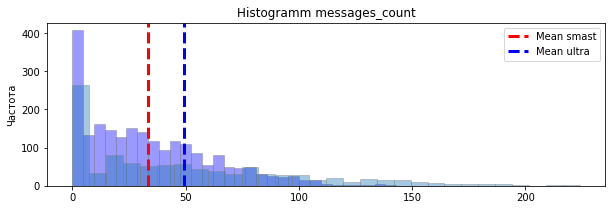

In [35]:
hist_maker_combi(smart['messages_count'], ultra['messages_count'])

Cреднее количество 33.384028712427096
Дисперсия 28.221542886898938
Стандартное отклонение 796.455482917076


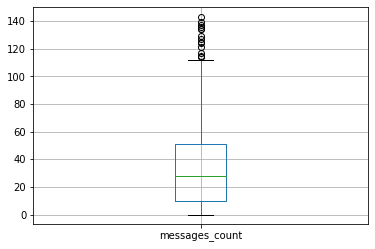

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_count, dtype: float64
-------
Cреднее количество 49.36345177664975
Дисперсия 47.78018496610161
Стандартное отклонение 2282.9460753948824


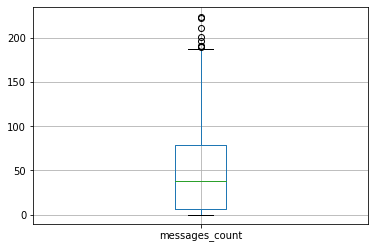

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_count, dtype: float64
-------


In [36]:
boxpot_maker(smart, 'messages_count')
boxpot_maker(ultra, 'messages_count')

***Выводы по использованию сообщений в разных тарифах:***
* И при этом в среднем клинеты тарифа Smart рассылают около 30 сообщений в день, а Ultra - около 50. 
* 75% клинетов Smart укладывается в лимит 50 сообщений, а для Ultra 75% клинетов 79 сообщений при включенной 1000
* Такое сильное отличие из-за того, что у клинетов с тарифом Ultra больше дисперсия, что говорит о большом разбросе данных от среднего значения

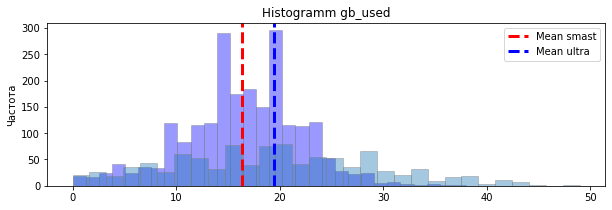

In [37]:
hist_maker_combi(smart['gb_used'], ultra['gb_used'])

Cреднее количество 16.328847016599372
Дисперсия 5.745771267187499
Стандартное отклонение 33.013887454837445


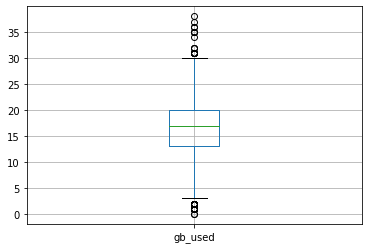

count    2229.000000
mean       16.328847
std         5.747061
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64
-------
Cреднее количество 19.494416243654822
Дисперсия 9.848508314957494
Стандартное отклонение 96.99311602978689


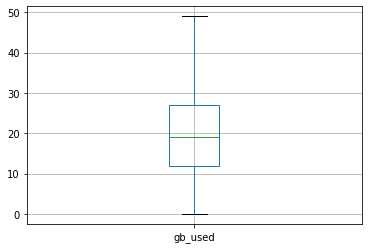

count    985.000000
mean      19.494416
std        9.853511
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64
-------


In [38]:
boxpot_maker(smart, 'gb_used')
boxpot_maker(ultra, 'gb_used')

**Выводы по использованию интренета в разных тарифах:**
* Средние в обоих случаях практически одинаковые, при том, что лимиты у талифов разные
* При этом стандартное отклонение сильно отличается и есть клинеты Ultra которые используют трафик знчительно больше лимита

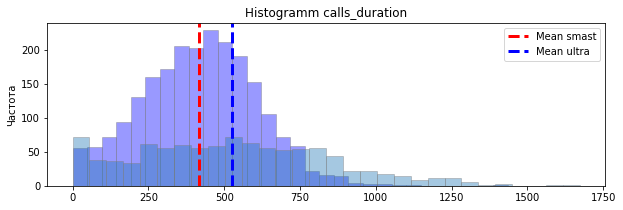

In [39]:
hist_maker_combi(smart['calls_duration'], ultra['calls_duration'])

Cреднее количество 417.9349484073576
Дисперсия 190.27103471651876
Стандартное отклонение 36203.06665209469


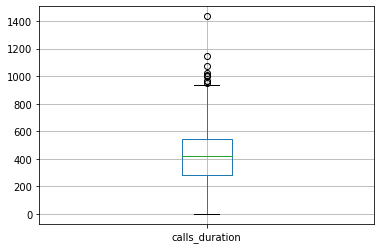

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: calls_duration, dtype: float64
-------
Cреднее количество 526.6233502538071
Дисперсия 317.44483554974113
Стандартное отклонение 100771.2236172022


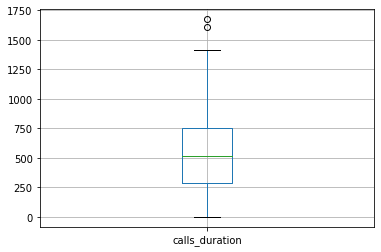

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: calls_duration, dtype: float64
-------


In [40]:
boxpot_maker(smart, 'calls_duration')
boxpot_maker(ultra, 'calls_duration')

**Выводы по использованию звонков в разных тарифах:**
* Большенство клинетов тарифа Smart разговаривают около 500 минут, что соответвует включенному лимиту
* У клинетов тарифа Ultra нет явно выраженного пика и любое кол-во минут разговора встречается однакого часто
* Так же повторяется ситуация с большим разбросом стандартного откорнения для Ultra из-за которого среднее смещено влево отновилено Smart
* для тарифа Ultra никто не использует весь лимит разговров - максимальное значение отличется в 2 раза от лимита

### Проверка гипотезы 1
***Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются***
  * Н0 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны, т.е. средние значения равны
  * Н1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны, т.е. средние значения не равны

In [41]:
results = st.ttest_ind(smart['revenue'], ultra['revenue']) # Метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

p-значение:  1.4229814360764067e-160
Принимаем альтернативную гипотезу


In [42]:
print(ultra['revenue'].describe())

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue, dtype: float64


In [43]:
print(smart['revenue'].describe())

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: revenue, dtype: float64


Из полученных результатов можно сделать вывод, то H0, не подтверждается и Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны.

### Проверка гипотезы 2
***средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов***
  * H0 - Средняя выручка пользователей из Москвы и всех остальных регионов равны для всех тарифов, т.е. средние значения равны
  * H1 - Средняя выручка пользователей из Москвы и всех остальных регионов НЕ равны для всех тарифов, т.е. средние значения не равны

In [44]:
sample_1 = data[data['city'] == 'Москва']['revenue'] 
sample_2 = data[data['city'] != 'Москва']['revenue'] 
results = st.ttest_ind( sample_1, sample_2)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

p-значение:  0.5440152911670224
Опровергнуть нулевую гипотезу нельзя


In [45]:
print(data[data['city'] == 'Москва']['revenue'].describe())
print(data[data['city'] != 'Москва']['revenue'].describe())

count     611.000000
mean     1546.713584
std       752.088071
min       550.000000
25%       780.500000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: revenue, dtype: float64
count    2603.000000
mean     1524.936227
std       808.787752
min       550.000000
25%       750.000000
50%      1583.000000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64


Из полученных резульиатов можно сделать вывод, то гипотиза H0 подтверждается и средняя выручка пользователей из Москвы и всех остальных регионов равны для всех тарифов

### Общий вывод:
* Из исходных данных было удалено 2 клинета, котрые не пользователись связью. Так же были Клинты, которые  не пользовались 
опреденного вида связью, напраимер, сообщения или звонки или интернет.
* Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны. «Ультра» более доходная.
* Средняя выручка пользователей не зависит от города(например, средняя выручка пользователей из Москвы и всех остальных регионов равны для всех тарифов)
* Предлагаю тариф Ultra оптимизировать, так как присутвует большое разброс в использовании включеных лимитов - возможно стоит выделить пользователй, которые реально больше пользуюся связью в отдельную группу
  * тариф ultra оставить для клиентов, котрые реально много пользуются связью - интрнет, сообщения, звонки. Можно предложить поднять абоненскую плату, но зато увеличить лимиты на сообщения и интернет, а так же уменьшить стоимость минунт разговора сверх лимита или лимит звонков (так как мало кто использует текущий лимит звонков в тарифе ultra, это будет приятный бонус)
  * создать новый тариф ultra light, так как не все клиенты ultra используют весь лимит по звонкам и смс. В новом тарифе снизить кол-во включенных лимитов относительно ultra, но оставить выше чем в smart. Предлагаю следующие лимиты: смс - 80, интернет- 25, звонки - 750 (взяла по 3-му квантилю). При этом и абонентская плата должна быть выше Smart, но ниже Ultra. Чтобы это было экономически выгодно предлаю для ultra light поднять плату за использование сверх лимита относительно smart.
* 75% пользователй всех тарифов используют трафика больше чем установенные лимиты, по этому есть предложение тарифу Smart так же поднять лимит для трафика до 20 гб в мес, чтобы заработить на этом есть предложение поднять абоненскую плату 